In [2]:
include("../scripts/kf.jl")

draw (generic function with 8 methods)

In [3]:
mutable struct FastSlam <: AbstractMcl
    particles
    map
    distance_dev_rate
    direction_dev
    motion_noise_rate_pdf
    ml
    pose
end

In [5]:
function FastSlam_(envmap, init_pose, particle_num, landmark_num, motion_noise_stds=Dict("nn"=>0.19, "no"=>0.001, "on"=>0.13, "oo"=>0.2),
        distance_dev_rate=0.14, direction_dev=0.05)
    self = FastSlam(ntuple(x->nothing, fieldcount(FastSlam))...)
    self.particles =[Particle(init_pose, 1.0/particle_num) for i in 1:particle_num]
    self.map = envmap
    self.distance_dev_rate = distance_dev_rate
    self.direction_dev = direction_dev
    v = motion_noise_stds
    c = Diagonal([v["nn"]^2, v["no"]^2, v["on"]^2, v["oo"]^2])
    self.motion_noise_rate_pdf = MvNormal(zeros(4), c)
    self.ml = self.particles[1]
    self.pose = self.ml.pose
    return self
end

FastSlam_ (generic function with 5 methods)

In [8]:
function trial()
    time_interval = 1.0
    world = World_(30, time_interval, false)
    
    m = Map()
    for ln in [[-4.0, 2.0], [2.0, -3.0], [3.0, 3.0]]
        append_landmark(m, Landmark(ln))
    end
    append(world, m)
    
    initial_pose = [0.0, 0.0, 0.0]
    pf = FastSlam_(m, initial_pose, 100, length(m.landmarks))
    a = EstimationAgent_(time_interval, 0.2, 10.0/180*pi, pf)
    r = Robot_(initial_pose, sensor=Camera_(m), agent=a, color="red")
    append(world, r)
    draw(world)
    showanim("test.mp4")
end

trial (generic function with 1 method)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAA2WNtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAGVJliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbZi9Ea0fjbwfl2o9ts0w9wdN5MJVeAjp2apf/nrOG4XqhXEOky0ViewaAExu4pV61UcgekdA1z3mTGfHUVi7lbjNjafsSusndiXhSJn8k8VhLU7uYRjxIdQ0M5ROE4eOe0Eev0A9OOL8/r81/6uO/7gObO3O8ikho5Gmu+TSMNye6np8b69hULJzIwzgFY4798RLsws18k5UOAeCwOlWwPO/Yh7LwJnPykhJTN9kY+OpWNFg6l3by+FnBglFK53i/Q76FzranJpKNyMajWn2P0NKgYsg0pdHCtadp/QrLQFGG/Uvsnr/YYD4WRXbXE39PfEt3WXzcLIFejx4Gt+Y5vXjx9188tPzEUQ37Zw/zgwWPNpTzLqavgaCxbScarwxPCvTEfjY2IgWiCV2TAmynCCVycdvV7xluoiPfvQtuifGsCs5YeZ9J8GpdY91b9ZGS2bIeFDnNqmEVKNhTQ1ZbpLevGpqcaYqUq2aJZqun5+76fMIuZBWOyg57h83Eu+5uwLKCuIj79ymNk1XCHAzGKD3YWFWfGN5XRBrCF3tVPXNXbx9HPf8QTAAVt9Q4lyS1fqGKiT8fcx7oCYg+e87WWgWxGxw7vs8ax91yfhkAMJnm/ijKcebk3F1H2kpsn0kCw48F2x3aP+7vWcmr8RBgdKtu93Pg8f6YlhIRg4yqJ7hRTVBAn/wNHo0P2OYh45MujiyHokxlMOyCYyOJmrGi1Pbr+HEd8S6kRivgnBThXHOb6n89X5zcam54bgihQIAhL6ShJKYQ3N/aMai3EmHqi+C/D3mlOzFNGHUndmehv5s7+L/K5ve+7xHN6viPVsPAyoMfuFrgHd3NX5Y4hfZNfKT4L7N+ZLNowKB5/K/IRbPWCEGJuyIlpFV286os75CLcL8uQe1wEMJP5Il8mQdJeItfx5XEonOJdn/YCYEUiLHlDZE9ae6E3jGtSIpQmYDPEd/bGtQs8AqKD4refyJLFnpcxurTm6apzXve4qA1dt+T2NBeoVm9o4qoJpuF1AE+KqbcVtT57IWR5C54NXWoGswf5Td29xnr7KwX7wFdQl1cgeQglIKuc5mVbrZFvmEkJ/6rj0SYlSdlnaYMWZW4oA0/Gs7tc0NVLOMfsyG4YUJxKfa7VvD4lBf7tLoRxnbfJs68QSKPUpFnpZNY+gIgz3iTi7thYfmzb8t2cZBCcf+gSJe01CHGIDRNqKjVp5QPm0b/aRloqcUvoStk43FE7PF3UNwSbd4L2gwe8Dk0iZIIgXIu8rqyDuLao8gcdxeC9kgNI3tyullNFxmeEX0zNkOGU1wBwgTvkVXmABThKQ/Gp3Pu9eCmW7sbIqtDRbZ7iKuF3efwOXU8ZJcRNfreEmhF2v8DLh5b56GUgKs80DZp4H8JOVEGyXMsyWAm7qYK5DfFqPiceZyFJ2QbU9Ztrmsvy6Rw6Gk5AXhkjDAU5CCtlqNLOEdZtSV7fBCq+EfORuuzYDLDAC2LTKE+5w/3S7Y5b+gQTANfct4zyjkaNkDQfnZv3ENmPlVBUWl98QkLYtpW1SbDKnvFDGX8tMq8jOAzEI7aYDVX/MTqXzMcpxd1TjHDTQx0iV0fVciiQDBVZ3ilrgI7EMgITJyBcB7pWQe2Fc/bJyOviFlZs6UpNPRlQ/4DXNb83EahP/+asHAfTslIBKguP3oFU+Ka2KxMD0gJhkOkS2XzaV2xeILxllI4BufifWfZSDRkK+V6khl97/oEAOzw3X1HG8RZYpdRXseajcJQPGVVTBuYraq27zjQvVi4wE3L0agPleXWulqMybMXqdEXSlvb2ffY2aCqvSf1jQ9S5xP2CmS5PGEUbJpXGNUQlXkR1fN740GiS9/N/cOm+yvlIN+92shWxjhI2EDJd4VIAP+vNZ6p+JtPBIFhB9VWjNBHzdgMMYeHCyoPBBaYcecQkwTzj+ePtrp40Wl2ZBxxaWYzXV+LVdP7vzJ2L8r1QgXbjTugG0/5Zf0wVhJcVW6UXYM+htJp4AmPW+PpHv+wGZ9PQEYUpmX+pt/eVVsdjoT0BsAvWLUFQ3leSXgiB6cXISF6pJPDnFaWw7KzSs/KoZaB6FuBtHVGgwkPOUgsWEmoYD9rdsUPUEDYJidp1fZYnNO3OPCZvfrI3ceBH/xsFYDd2YycVrAlCH0RMM5fuKl3fkCrw3F/nluoL9KEufp7SO4OCKqan2v1XlIWF0hUjIjKFYY/dWQDSUNZvWk9jb7kjPYH2bTrglsMFE2x+n9sTslMFZGJDI8fuIyMe6x4xLcylAZ6XLFfJzoKeIZ0ZbpUx/+Um47giZIrSRaDH5lnPS2Uo9+nnz5OlzWlhq+QIgPX+asp1RM0XsQkCsOZhC46Uz7f3xyJDJHvrJb2PCfBdTnrKKIHt7h4mL5p+8bVkDiJa3HMJDiIiJdRQ3P9EENhKqGHCrHmebs+lGxWNDDhb/CtdRZgRM0/Zt6RA+6DBT6CL2LZU+3Y9s++hZMmB+fr/rHiAnCwVuQsocEcmj9+97VEIB1PAFKs1J+vSbIdqnm6wJ8oLLWCnDyyf0jRaxhWUxiue/zB1engWBT0FVcQT/7iKj9c6vdL/

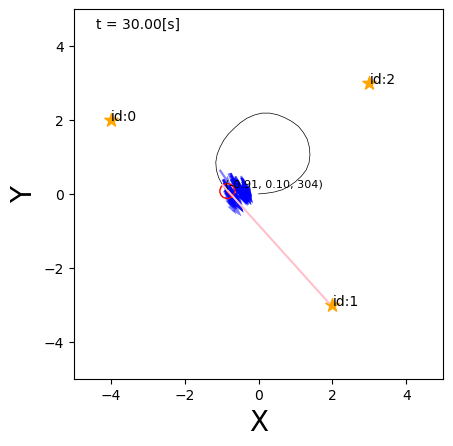

In [9]:
trial()